# Implementing Gradient Descent and Stochastic Gradient Descent Optimization Algorithms from Scratch

Typically machine learning practioners use a library like `sklearn` and its built-in class `LogisticRegression` to find the weights for the logistic regression problem.   The `fit` routine in that class has an *optimizer* to select the weights to best match the data (i.e. minimizes the training loss). 

In this project the goal is to understand how an optimizer, like the one inside the `LogisticRegression` class works. Within this project a very simple gradient descent optimizer is built from scratch.

The project has the following goals:

* Computing the gradients of a loss function and implementing the gradient calculations in Python
* Implement a simple gradient descent optimizer
* Visualize the effect of the learning rate in gradient descent
* Implement an adaptive learning rate algorithm
* Add regularization to the loss minimization problem
* Try out different black-box optimizers in Python

## 1. Loading the Breast Cancer Dataset

The dataset used in this project is the Breast Cancer Wisconsin (Original) Data Set,
a widely used benchmark for binary classification in medical diagnostics. Each sample
represents a fine needle aspirate (FNA) of a breast mass, with features describing
characteristics of the cell nuclei present in the image.

**Features:** There are nine predictive features, all integer-valued in the range 1–10,
representing:
  - Clump Thickness (`thick`)
  - Uniformity of Cell Size (`size_unif`)
  - Uniformity of Cell Shape (`shape_unif`)
  - Marginal Adhesion (`marg`)
  - Single Epithelial Cell Size (`cell_size`)
  - Bare Nuclei (`bare`)
  - Bland Chromatin (`chrom`)
  - Normal Nucleoli (`normal`)
  - Mitoses (`mit`)
An additional column (`id`) is a sample identifier and is not used for prediction.


**Labels:** The target variable (`class`) is categorical:
  - 2 = Benign
  - 4 = Malignant
For modeling, these are converted to binary labels: 0 for benign, 1 for malignant.

**Citation:**
W.N. Street, W.H. Wolberg and O.L. Mangasarian. "Nuclear feature extraction for breast tumor diagnosis."
IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, 861-870, 1993.
UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)




In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


Next load the data from the BCW dataset

In [3]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head()

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


Create a data matrix `X` of various features of the breast cancer sample. Also create the response vector `y` with binary elements indicating if each sample is benign or malignant.  

In [4]:
# Get the predictors
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
Xraw = np.array(df[xnames])
# Append an all ones vector onto X to serve as the intercept feature
X = np.concatenate((np.ones((Xraw.shape[0],1)),Xraw),axis=1)

# Get the response.  Convert to a zero-one indicator
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int) # now y has values of 0,1; 1 for malignant, 0 for benign
Iben = (y==0) #boolean mask (array) with 1's for benign samples
Imal = (y==1) #boolean mask (array) with 1's for malignant samples


We want to learn the classification rule to predict `y` from `X`.  We will do so with logistic regression.

## 2. Computing the Gradient and Loss Function


This section implements the core mathematical components required for training a logistic regression model through gradient-based optimization. The binary classification rule is defined by a weight vector $\beta$ such that:

* A data vector $\vec{x}$ is classified as positive (1) when $\vec{x}^T\vec{\beta} > 0$
* A data vector $\vec{x}$ is classified as negative (0) when $\vec{x}^T\vec{\beta} \leq 0$

The sigmoid function $h_{\vec{\beta}}(\vec{x}) = \frac{1}{1 + e^{-\vec{x}^T\vec{\beta}}}$ transforms the linear combination into a probability. The optimal $\beta$ is found by minimizing the binary cross-entropy loss function (aka logistic loss function):


$$
L(\vec{\beta}) = - \sum_{i=1}^n y_i \log(h_{\vec{\beta}}(\vec{x}_i)) + (1-y_i) \log(1-h_{\vec{\beta}}(\vec{x}_i)).
$$

**Numerical Stability Considerations:** The standard cross-entropy formulation can exhibit numerical instability when computing logarithms of values near zero, potentially resulting in NaN values due to finite precision arithmetic limitations. To address this, we employ a mathematically equivalent but numerically stable alternative:


### Numerical Stabilty Consideration: Adjusting the Cross-Entropy Loss Function
One issue with the standard cross-entropy formulation above for $L$ is that it can exhibit *numerical instability*. Essentially what can happen is you end up taking logs of numbers very close to zero and Python will return NaNs due to issues with using finite precision arithmetic. To deal with this problem, an alternative expression for `L` is provided. This alternative expression  is *mathematically equivalent* but can be computed more accurately in finite precision arithmetic:
$$
L(\vec{\beta}) = \sum_{i=1}^n (1-y_i)(\vec{x}_i^T\vec{\beta}) - \log(h_{\vec{\beta}}(\vec{x}_i)).
$$

**Gradient Computation:** The gradient of the loss function with respect to $\beta$ is analytically derived as:

$$
\nabla L(\vec{\beta}) = \mathbf{X}^T(h_{\vec{\beta}}(\mathbf{X}) - y)
$$

where $h_{\vec{\beta}}(\mathbf{X})$ represents the vector of sigmoid outputs applied to each row of the feature matrix $\mathbf{X}$
    
    
**Implementation Notes:** While the logistic loss function is differentiable and its gradient can be explicitly computed, the equation $\nabla L(\boldsymbol{\beta}) = 0$ cannot be solved algebraically for a closed-form solution. This necessitates the use of iterative optimization methods such as gradient descent.

The following implementation computes both the loss value and its gradient efficiently for use in optimization algorithms.

In [5]:
def Leval(beta,X,y):
    """
    Compute the loss and gradient given beta,X,y
    """
    z = X@beta
    h = 1/(1+np.exp(-z))
    L = np.sum((1-y)*z - np.log(h))

    # Gradient
    Lgrad = (X.T)@(h-y)
    return L, Lgrad

Test the `Leval` function on a random parameter vector $\vec{\beta}_0$.

In [6]:
# Some random point
p = X.shape[1]
beta0 = np.random.randn(p) # creates a p-dimensional random vector where each element is drawn from a normal distribution with mean 0 and variance 1

# Call the function
L, Lgrad = Leval(beta0,X,y)

In [7]:
# Create a function with X,y fixed in order to reflect a standard gradient and loss calculation interface for a numerical optimizer
Leval_param = lambda beta: Leval(beta,X,y) # lambda function creates a closure fixing X and y at the time of lambda function definition

# You can now pass a parameter like w0
L0, Lgrad0 = Leval_param(beta0)

### Gradient Verification

It is essential to rigorously verify the correctness of any custom gradient implementation. Incorrect gradients are a common source of failure when using numerical optimization algorithms. A standard approach is to select two parameter vectors, `beta0` and `beta1`, that are close to each other, and confirm that the following first-order Taylor approximation holds:

$$
L(\vec{\beta}_1) - L(\vec{\beta}_0) \approx \langle \nabla L(\vec{\beta}_0), \vec{\beta}_1 - \vec{\beta}_0\rangle.
$$

This check provides strong evidence that the analytical gradient matches the true local behavior of the loss function.

In [8]:
# Take a random initial point
p = X.shape[1]
beta0 = np.random.randn(p)

# Perturb the point
step = 1e-6
beta1 = beta0 + step*np.random.randn(p)

# Measure the function and gradient at w0 and w1
L0, Lgrad0 = Leval_param(beta0)
L1, Lgrad1 = Leval_param(beta1)

# Predict the amount the function should have changed based on the gradient
dL_est = Lgrad0.T@(beta1-beta0)

# Print the two values to see if they are close
print("Actual L1-L0    = %12.4e" % (L1-L0))
print("Predicted L1-L0 = %12.4e" % dL_est)

Actual L1-L0    =   2.0057e-03
Predicted L1-L0 =   2.0057e-03


Above we have confirmed the actual difference in loss between $\beta_0$ and $\beta_1$ and the first-order approximation are almost exactly equal (exactly equal in this case of the numerical precision of host machine running this original notebook). Even if the block is ran multiple times to get different answers (due to the random choice of $\beta_0$), there is always agreement.

## 3. A Simple Gradient Descent Optimizer

Below is a simple gradient descent optimizer function with a fixed learning rate.

In [9]:
def grad_opt_simp(grad_func, beta0, lr=1e-3,nit=1000):
    """
    Simple gradient descent optimization

    grad_func:  A function that returns the objective function L, and its gradient Leval
    beta0:  Initial estimate for parameters beta
    lr:     learning rate
    nit:    Number of iterations
    """

    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer
    # useful for debugging
    hist = {'beta': [], 'L': []}

    # initialize
    beta = beta0

    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        L, Lgrad = grad_func(beta)

        # Take a gradient step
        beta = beta - lr*Lgrad

         # Save history
        hist['L'].append(L)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, L, hist

Test the gradient descent optimizer starting from an initial condition of $\vec{\beta}_0 = \vec{0}$.

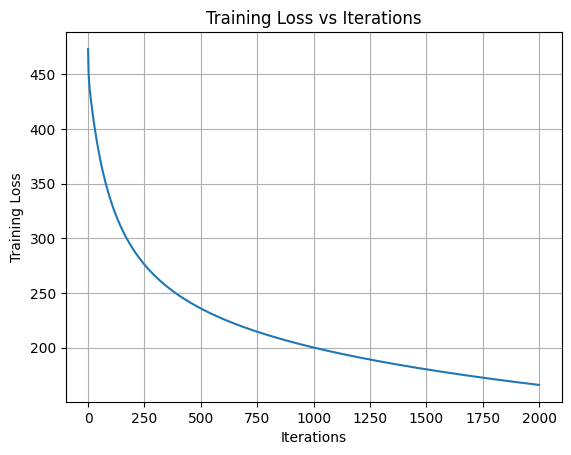

In [10]:
# Initial condition
beta0 = np.zeros(p)

# Parameters
nit = 2000
lr = 1e-5  #small learning rate then parameter default

# Run the gradient descent
beta, L, hist = grad_opt_simp(Leval_param, beta0, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)
plt.plot(t, hist['L'])
plt.title('Training Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.grid()

 Create a predict method to measure the accuracy of the final estimated optimal parameter vector $\beta$.

In [ ]:
def predict(X,beta):
    z = X@beta
    yhat = (z > 0)
    return (1*yhat) #multiplying by 1 converts each True/Fasle in the boolean array to 1/0

In [ ]:
yhat = predict(X,beta)
acc = np.mean(yhat == y) # True Postive / (True Postive + False Negative)
print("Train accuracy = %f" % acc)

Train accuracy = 0.941435


The accuracy  is not quite up to industry-standards (like usuing optimizers from `sklearn`) because the learning rate was somewhat slow (too small) and the aboce optimization loop didn't yet achieve full convergence.

To see the effect of the learning rate, the code below tries different learning rates.

lr=    1.00e-05  Train accuracy = 0.941435
lr=    1.00e-04  Train accuracy = 0.969253
lr=    1.00e-03  Train accuracy = 0.970717
lr=    1.00e-02  Train accuracy = 0.964861


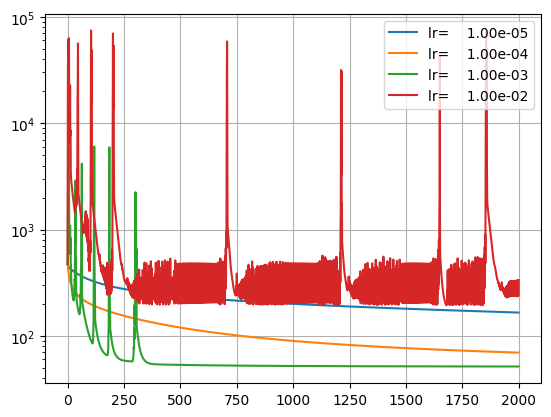

In [22]:
# Learning rate values to test
lr_test = [1e-5,1e-4,1e-3, 1e-2]
ntest = len(lr_test)

# Strings for the legend
leg_str = []

# p ia a random initial point
# p = X.shape[1]
# p = 10

beta0 = np.zeros(p)
for i in range(ntest):
    # Run the optimizer
    beta, L, hist = grad_opt_simp(Leval_param, beta0, lr=lr_test[i], nit=nit)

    # Plot the results
    plt.semilogy(t, hist['L'])
    leg_str.append("lr=%12.2e" % lr_test[i])

    # Measure the train accuracy
    yhat = predict(X,beta)
    acc = np.mean(yhat == y)
    print("lr=%12.2e  Train accuracy = %f" % (lr_test[i], acc))

plt.grid()
plt.legend(leg_str, loc='upper right')

From above: increasing the learning rate, speeds the convergence time, but the optimization begins to go unstable. It recovers from this instability for learning rate `1e-3`, but running with rate `1e-2` leads to more instability and a covergence to a higher minimum loss value (likely a local minimum on the loss surface).

## 4. Implementing Adaptive Step Size

The above example shows that gradient descent is sensitive to the step size.  In order to deal with this issue a variant of gradient descent with an adaptive step-size using the Armijo rule is developed below.

In [ ]:
def grad_opt_adapt(grad_func, beta0, nit=2000, lr_init=1e-3):
    """
    Gradient descent optimization with adaptive step size

    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    beta0:  Initial estimate
    nit:    Number of iterations
    lr_init:     Initial learning rate
    """

    # Set initial point
    beta = beta0
    lr = lr_init

    # Create history dictionary for tracking progress per iteration.
    # not necessary for the final answer
    # is useful for debugging
    hist = {'lr': [], 'beta': [], 'L': []}

    L,Lgrad = grad_func(beta0) # returns the loss and the gradient (of the Loss w.r.t. beta) evaluated at initial beta
    for it in range(nit):

        # Take a gradient step
        beta1 = beta - lr*Lgrad

        # Evaluate the test point (test/current beta) by computing the objective function, L1,
        # at the test point and the predicted decrease, df_est
        L1, Lgrad1 = grad_func(beta1)
        df_est = Lgrad.T@(beta1-beta)

        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (L1-L < alpha*df_est) and (L1 < L):
            # If descent is sufficient(if the actual deecrease is less than (more negative) then half the predicted decrease), accept the point and increase the learning rate
            lr = lr*2 # 
            L = L1
            Lgrad = Lgrad1
            beta = beta1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2

        # Save history
        hist['L'].append(L)
        hist['lr'].append(lr)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'lr', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, L, hist


Run the new optimizer with the adaptive step-size.

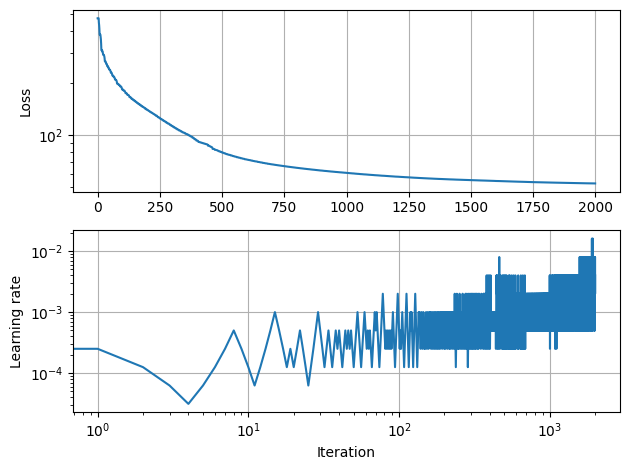

In [ ]:
beta0 = np.zeros(p)
nit = 2000
beta, L, hist = grad_opt_adapt(Leval_param, beta0, nit=nit)

t = np.arange(nit)
plt.subplot(2,1,1)
plt.semilogy(t, hist['L'])
plt.grid()
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.loglog(t, hist['lr'])
plt.grid()
plt.ylabel('Learning rate')
plt.xlabel('Iteration')
plt.tight_layout()

Below we measure the accuracy and see that the optimizer with adaptive step-size performed as well as the best fixed-step size used in the simplier gradient descent optimizer used earlier.

In [26]:
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("Train accuracy = %f" % acc)

Train accuracy = 0.970717


## 5. Adding L2 Regularization to the Optimizer's Objective Function

Similar to linear regression, logistic regression models with high-dimensional feature spaces are susceptible to overfitting. To mitigate this issue, regularization techniques are commonly employed during model training. Specifically, rather than minimizing the unregularized loss function:

$$
L(\mathbf{\vec{\beta}}) =\sum_{i=1}^n (1-y_i)(\vec{x}_i^T\vec{\beta}) - \log(h_{\vec{\beta}}(\vec{x}_i))
$$

we implement $\ell_2$ regularization by augmenting the objective function with a penalty term:

$$
L_R(\vec{\beta}) = L(\vec{\beta}) + \lambda \|\vec{\beta}\|_2^2
$$

where $\lambda \geq 0$ is the regularization hyperparameter that controls the trade-off between model complexity (larger parameter vector norms) and training error. The $\ell_2$ penalty term $\|\vec{\beta}\|_2^2 = \sum_{j=1}^p \beta_j^2$ encourages smaller parameter values, thereby reducing model complexity and improving generalization performance.

Below `Leval` is rewritten to compute a regularized loss `Lr`.

In [29]:
# example loss and gradient evaluator function from earlier (unregularized logistic loss)

def Leval(beta, X, y):
    """
    Compute the loss and gradient given beta,X,y
    """
    z = X@beta
    h = 1/(1+np.exp(-z))
    L = np.sum((1-y)*z - np.log(h))

    # Gradient
    Lgrad = (X.T)@(h-y)
    return L, Lgrad

In [ ]:
def Leval_reg(beta, X, y, lamb):
    """
    Compute the regularized loss, Lr, and regularized gradient, Lrgrad, given beta, X, y, and regularization parameter lamb
    """
    #get the gradient component from the 'data-fit' term, the unregularized logistic loss function
    L, Lgrad = Leval(beta, X, y)

    # gradient of the regularization term is added to the gradient of the unregularized loss function
    Lrgrad = Lgrad + 2*lamb*beta
    Lr = L + lamb*np.sum(beta**2) 

    return Lr, Lrgrad

# Create a function with X,y fixed to conform with standard numerical optimization framework interface
Leval_reg_param = lambda beta, lamb: Leval_reg(beta, X, y, lamb)

Below the gradient optimizer function is adpated so that it is compapatible with the regularized loss function `Leval_reg`.

In [ ]:
#modify the gradient descent algorithm with adaptable learning rates
#add regulariation term functionality

def grad_opt_adapt_reg(grad_func, beta0, lamb, nit=2000, lr_init=1e-3):
    """
    Gradient descent optimization with adaptive step size and a regularized loss function

    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    beta0:  Initial estimate
    nit:    Number of iterations
    lr_init:     Initial learning rate
    """

    # Set initial point
    beta = beta0
    lr = lr_init

    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it
    # is useful for debugging
    hist = {'lr': [], 'beta': [], 'Lr': []}

    Lr,Lrgrad = grad_func(beta0, lamb) # returns the loss and the gradient (of the Loss w.r.t. beta) evaluated at initial beta
    for it in range(nit):

        # Take a gradient step
        beta1 = beta - lr*Lrgrad

        # Evaluate the test point (test/current beta) by computing the objective function, L1,
        # at the test point and the predicted decrease, df_est
        L1, Lrgrad1 = grad_func(beta1, lamb)
        df_est = Lrgrad.T@(beta1-beta)

        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (L1-Lr < alpha*df_est) and (L1 < Lr):
            # If descent is sufficient(if the actual deecrease is less than (more negative) then half the predicted decrease), accept the point and increase the learning rate
            lr = lr*2
            Lr = L1
            Lrgrad = Lrgrad1
            beta = beta1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2

        # Save history
        hist['Lr'].append(Lr)
        hist['lr'].append(lr)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('Lr', 'lr', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, Lr, hist


Now the effect varying the regularization parameter `lamb` has on model performance is evaluated. The values of 0, 1, 10, and 100 are used for `lamb`. For each value, the adaptive gradient descent optimizer (`grad_opt_adapt`) is executed for 2000 iterations, starting from an initial parameter vector $\vec{\beta}_0 = \vec{0}$, to approximate the minimizer of $L_R(\beta)$. The resulting training accuracy is reported for each regularization level. As the regularization strength increases, a corresponding decrease in training accuracy is typically observed.

In [ ]:
lamb_list = [0, 1, 10, 100]
lamb_hist = {lamb: None for lamb in lamb_list}

beta0 = np.zeros(p)
nit = 2000
final_beta_list = [None] * len(lamb_list)

for i in range(len(lamb_list)):
    #run GD with adaptive learning rate and L2 Regularization for current lambda parameter
    final_beta, final_Reg_Loss, hist = grad_opt_adapt_reg(Leval_reg_param, beta0, lamb_list[i], nit)

    #store each lamb iteration history (across all betas/learning rates during each GD process)
    lamb_hist[lamb_list[i]] = hist
    final_beta_list[i] = final_beta


for i in range(len(lamb_list)):

    yhat = predict(X,final_beta_list[i])
    acc = np.mean(yhat == y)
    print(f"lamb = {lamb_list[i]}, Train accuracy = {acc:.5f}")


lamb = 0, Train accuracy = 0.97072
lamb = 1, Train accuracy = 0.96925
lamb = 10, Train accuracy = 0.95900
lamb = 100, Train accuracy = 0.92094


## 6. Implementing a Stochastic Gradient Descent Optimizer

For very large data sets, implementing full gradient descent can be impractical, so stochastic gradient descent is used instead.
In this next section, the goal is to implement a stochastic gradient oracle and corresponding stochastic gradient descent optimizer to minimize the logistic loss function.


First a function that computes the following gradient is defined:

$$
L_j(\vec{\beta}) = (1 - y_j)\vec{x}_j^T \vec{\beta} - \log(h_{\vec{\beta}}(\vec{x}_j))
$$

for any $j$. 

The fucntion takes the vector $\vec{x}_j$ and label $y_j \in \{0,1\}$ as input. Note that

$$
L(\vec{\beta}) = \sum_{i=1}^n L_j(\vec{\beta}),
$$

with the following expectation, $n \cdot \mathbb{E}[\nabla L_j(\vec{\beta})] = \nabla L(\vec{\beta})$.


In [ ]:
def Leval_stoc(beta,x,y):
    """
    Compute the stochastic gradient given beta, vector x, and single label y
    Note that, unlike before, your function should not compute the loss function value,
    as this would be more expensive then computing the stochastic gradient
    """

    z = x@beta
    h = 1/(1+np.exp(-z))

    # Gradient
    Lgrad_stoc = (h-y) * x

    return Lgrad_stoc

In [55]:
# Create a function with X,y fixed
Leval_stoc_param = lambda beta: Leval_stoc(beta, X, y)

Just as for the standard gradient oracle, check that the stochastic gradient is being computed directly. This is done by verifying that $n\cdot \mathbb{E}[\nabla L_j(\vec{\beta})] = \nabla L(\vec{\beta})$. To do so, $\mathbb{E}[\nabla L_j(\vec{\beta})]$ can be estiated using a large sample of data points and then compared to $\nabla L(\vec{\beta})$. 

Below, $\mathbb{E}[\nabla L_j(\vec{\beta})]$ is estimated using 10000 random samples.

In [ ]:

# Pick a random test beta
beta_test = np.random.randn(p)

# Get many indices for random sampling of datapoints 
m = 10000
n = X.shape[0]
idxs = np.random.randint(0, n, size=m)

# Accumulate the individual gradients of each sampled datapoint
grad_accum = np.zeros_like(beta_test)
for j in idxs:
    grad_accum += Leval_stoc(beta_test, X[j, :], y[j])  # single-sample gradient


stoc_grad_est = (n / m) * grad_accum

# 5. Compare to the full batch gradient
L_full, Lgrad_full = Leval(beta_test, X, y)   # from your earlier logistic loss
print("‖n * Average(delta_L_j) - delta_L‖ =", np.linalg.norm(stoc_grad_est - Lgrad_full))



‖n * Average(delta_L_j) - delta_L‖ = 39.9962481752303


Below we use the stochastic gradient oracle, `Leval_stoc`, to implement a stochastic gradient descent optimizer with a fixed learning rate.

Here the history of losses at every iteration is logged. While this is computationally expensive, it is done for subsequent comparison and visualization purposes.

In [ ]:
def stoc_grad_opt(X, y, stoc_grad_func, beta0, lr=1e-3, nit=1000):
    """
    Stochastic Gradient Descent for unregularized logistic loss
    using Leval_stoc (single-sample gradient).

    
    stoc_grad_func:  A function that returns the stochastic gradient of the lost for a given input rows of X and entry of y
    beta0:  Initial estimate for parameters beta
    lr:     learning rate
    nit:    Number of iterations
    """
    n, p = X.shape
    beta = beta0.copy()

    # For tracking progress
    hist = {'beta': [], 'L': []}

    for it in range(nit):
        # Evaluate full logistic loss for debugging/logging
        L, _ = Leval(beta, X, y)
        hist['beta'].append(beta.copy())
        hist['L'].append(L)
        
        # Pick a random data index for this iteration
        j = np.random.randint(0, n)
        
        # Compute single-sample gradient (stochastic gradient)
        grad_stoc = Leval_stoc(beta, X[j], y[j])
        
        # Gradient descent update
        beta = beta - lr * grad_stoc

    # Evaluate full logistic loss one final time
    L_final, _ = Leval(beta, X, y)
    return beta, L_final, hist

Now the stochastic gradient descent optimizer is ran starting from initial condition $\boldsymbol{\beta}_0 = \vec{0}$. The output is then plotted. 

*Notice:* even for small learning rates, the loss does not necessarily decrease monotonically due to randomness inherent in the stochastic method.

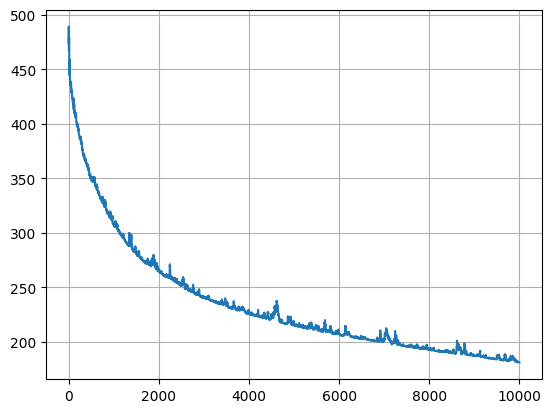

In [ ]:
# Initial condition
beta0 = np.zeros(p)

# Parameters
nit = 10000
lr = 1e-3

# Run the gradient descent
beta, L, hist = stoc_grad_opt(X, y, Leval_stoc, beta0, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)
plt.plot(t, hist['L'])
plt.title('Training Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.grid()

## 7. Comparing Stochastic Gradient Descent Optimizer with the Adpative Learning Rate Optimizer

To align the logging of the stochastic gradient descent optimizer with that of the gradient descent optimizer using adaptive learning rates, the stochastic optimizer is modified to accept the number of epochs as an argument instead of the number of iterations. Within each epoch, the entire dataset is iterated over (with optional shuffling of the data), updating the parameters for each sample. The full loss function value is computed and logged only at the end of each epoch. This approach ensures that the loss history is recorded once per epoch, making the outputs of both optimizers directly comparable.

In [ ]:
def stoc_grad_opt_epoch(X, y, stoc_grad_func, beta0, lr=1e-3, nepoch=500):
    """
    Simple stochastic gradient descent optimization

    stoc_grad_func:  A function that returns the stochastic gradient of the lost for a given input rows of X and entry of y
    beta0:  Initial estimate for parameters beta
    lr:     learning rate
    nepoch:    Number of epochs of training
    """

    n, p = X.shape
    beta = beta0.copy()
    
    # Dictionary to store the parameter vector and full loss after each epoch
    hist = {'beta': [], 'L': []}
    
    for epoch in range(nepoch):
        # Shuffle the data indices for this epoch
        idxs = np.random.permutation(n)
        
        # Loop over each sample in random order
        for j in idxs:
            # Compute single-sample gradient
            grad_stoc = stoc_grad_func(beta, X[j], y[j])
            # Gradient descent update
            beta = beta - lr * grad_stoc
        
        # Compute the full batch loss once per epoch
        L_epoch, _ = Leval(beta, X, y)
        
        # Store results
        hist['beta'].append(beta.copy())
        hist['L'].append(L_epoch)
    
    # Final loss after last epoch
    L_final, _ = Leval(beta, X, y)
    return beta, L_final, hist


Now both the stochastic gradient descent method and the standard gradient descent method with adaptive step size (`grad_opt_adapt`) are ran for 500 epochs.

A plot of the loss function errors obtained at the end of each epoch for each optimzer is below. From the plot, given an appropriate choice of step size, it is evident that the stochastic gradient descent optimizer requires fewer epochs to reach near a minimal loss in comparison to standard adaptive learing rate gradient descent optimizer.

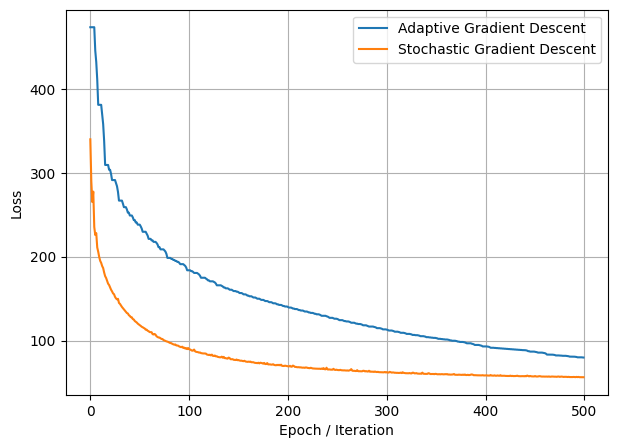

In [ ]:
beta0 = np.zeros(p)

beta_sgd, L_sgd, hist_sgd = stoc_grad_opt_epoch(
    X, y,
    Leval_stoc,
    beta0,
    lr=1e-3,
    nepoch=500
)

# Run full-batch gradient descent with adaptive step size for 500 iterations
beta_adapt, L_adapt, hist_adapt = grad_opt_adapt(Leval_param, beta0, nit=500, lr_init=1e-3)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(hist_adapt['L'], label='Adaptive Gradient Descent')       # 1 loss value per iteration
plt.plot(hist_sgd['L'], label='Stochastic Gradient Descent' )       # 1 loss value per epoch
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()